# Восстановление золота из руды

Необходимо подготовить прототип модели машинного обучения, предсказывающую коэффициент восстановления золота из золотосодержащей руды, на основе данных с параметрами добычи и очистки. 
Эта модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Данные уже разделены на тренировочную и тестовую выборки, однако часть тестовых данных отсутсвует (их необходимо восстановить при предобработке).

Эффективность обогащения рассчитывается по формуле:

$$
Recovery  = \frac{C * (F - T)}{F*(C-T)} * 100\%
$$

где:
- $C$ — доля золота в концентрате после флотации/очистки;
- $F$ — доля золота в сырье/концентрате до флотации/очистки;
- $T$ — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.


Качество данной модели измеряется в sMAPE:
$$
sMAPE = \frac{1}{N}\sum_{i=1}^{N}\frac{\left|y_{i} - \hat{y}_{i}\right|}{(\left|y_{i}\right|+ |\hat{y}_{i}|) / 2} * 100\%
$$

где:
- $y_{i}$ — значение целевого признака для объекта с порядковым номером $i$ в выборке, на которой измеряется качество.;
- $\hat{y}_{i}$ — значение предсказания для объекта с порядковым номером $i$, например, в тестовой выборке;
- $N$ — количество объектов в выборке..


Нужно спрогнозировать сразу две величины:
- эффективность обогащения чернового концентрата rougher.output.recovery;
- эффективность обогащения финального концентрата final.output.recovery.


Итоговая метрика складывается из двух величин:

$$
finalsMAPE = 25\% * sMAPE(rougher) + 75\% * sMAPE(final)
$$

Значения столбцов датасета:

<u>Технологический процесс</u>
- `Rougher feed` — исходное сырье
- `Rougher additions` (или `reagent additions`) — флотационные реагенты
- `Rougher process` — флотация
- `Rougher tails` — отвальные хвосты
- `Float banks` — флотационная установка
- `Cleaner process` — очистка
- `Rougher Au` — черновой концентрат золота
- `Final Au` — финальный концентрат золота.

<u>Параметры этапов</u>
- `air amount` — объём воздуха
- `fluid levels` — уровень жидкости
- `feed size` — размер гранул сырья
- `feed rate` — скорость подачи.

<u>Наименование признаков</u>

[этап].[тип_параметра].[название_параметра]

Пример: `rougher.input.feed_ag`

Возможные значения для блока [этап]:
`rougher` — флотация
`primary_cleaner` — первичная очистка
`secondary_cleaner` — вторичная очистка
`final` — финальные характеристики

Возможные значения для блока [тип_параметра]:
`input` — параметры сырья
`output` — параметры продукта
`state` — параметры, характеризующие текущее состояние этапа
`calculation` — расчётные характеристики.

## 1. Подготовка данных

### 1.1. Обзор данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import  make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.impute import KNNImputer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

In [2]:
df_train = pd.read_csv('datasets/gold_recovery_train_new.csv')
df_test = pd.read_csv('datasets/gold_recovery_test_new.csv')
df_full = pd.read_csv('datasets/gold_recovery_full_new.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [4]:
df_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [5]:
def show_info(df):
    name =[x for x in globals() if globals()[x] is df][0]
    missed_row = 0
    
    print('\033[1m' + 'Информация о датасете ' + name + '\n' + '\033[0m')
    for i in df.columns:
        if df[i].isna().sum()> 0:
            missed_row += 1
    
    print('столбцов:', df.shape[1])
    print('строк:', df.shape[0])
    print('дубликатов:', df.duplicated().sum())
    print('столбцов с пропусками:', missed_row)
    print('пропущенных значений в строках:', df.isnull().sum().sum())
    
    print('-'*100, '\n')

In [6]:
show_info(df_train)
show_info(df_test)
show_info(df_full)

Информация о датасете df_train

столбцов: 87
строк: 14149
дубликатов: 0
столбцов с пропусками: 62
пропущенных значений в строках: 4100
---------------------------------------------------------------------------------------------------- 

Информация о датасете df_test

столбцов: 53
строк: 5290
дубликатов: 0
столбцов с пропусками: 12
пропущенных значений в строках: 90
---------------------------------------------------------------------------------------------------- 

Информация о датасете df_full

столбцов: 87
строк: 19439
дубликатов: 0
столбцов с пропусками: 63
пропущенных значений в строках: 4481
---------------------------------------------------------------------------------------------------- 



В результате обзора данных, очевидны две проблемы:
 - число столбцов в тестовой выборке отличается от датасета с полным набораом данных и обучающей выборки: отсутсвуют 34 столбца,
 - все датасеты содержат многожество пропущенных значений, необходимо обработать пропуски. Явные дубликаты строк отсутствуют.

### 1.2.  Проверка формулы вычисления эффективности обогащения

Согласно условиям, формула рассчета эффективности обогащения выглядит следующим образом:

$$Recovery = (C * (F - T)) / (F * (C - T)) * 100%$$

<br>где:
- $C$ — доля золота в концентрате после флотации/очистки;
- $F$ — доля золота в сырье/концентрате до флотации/очистки;
- $T$ — доля золота в отвальных хвостах после флотации/очистки.

Используем данные обучающей выборки в этой формуле.

In [7]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

recovery = C * (F - T) / (F * (C - T)) * 100

recovery.describe()

count    14149.000000
mean        82.704502
std         14.479156
min         -0.000000
25%         79.993067
50%         85.299462
75%         90.165021
max        100.000000
dtype: float64

Рассчитаем средне абсолютное отклонение между рассчитанной эффективностью обогащения и данными о нем из обучающей выборки.

In [8]:
mean_absolute_error(recovery, df_train['rougher.output.recovery'])

9.682896147825551e-15

Среднее абсолютное отклонение небольшое, соответсвенно, параметр recovery в train рассчитан верно.

### 1.3.  Анализ признаков, недоступных в тестовой выборке

In [9]:
#Найдем 34 столбца, пропущенные в тестовой выборке.

test_absent = df_train.columns.drop(df_test.columns)
test_absent

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

 Из полученного списка можно сделать следующие выводы:
- из 34 пропущенных признаков 30 относятся к параметрам продукта, а 4 - к расчетным характеристикам,
- 9 пропущенных признаков этапа final, 8 primary_cleaner, 9 rougher, 4 secondary_cleaner относятся к параметрам продукта,
- на всех этапах, кроме повторной очистки отсутствует информация о доле металлов,
- на всех технологических этапах отсутствует информация об "отвальных хвостах",
- отсутствуют данные о некоторых реагентах на этапе флотации,
- у финального этапа и этапа флотации отсутствуют признаки обогащения.

### 1.4. Предобработка данных

Удалим строки с пропусками в целевом признаке.

In [10]:
df_train.dropna(subset=['final.output.recovery', 'rougher.output.recovery'], inplace=True)

df_test_drop = df_train.columns.drop(df_test.columns)
df_train.drop(df_test_drop, axis=1, inplace=True)

Используем дату в качестве индекса строк.

In [11]:
df_train.set_index('date', inplace=True)
df_test.set_index('date', inplace=True)
df_full.set_index('date', inplace=True)

Избавимся от пропусков в строках через метод ближайшего соседа.

In [12]:
def transform_imputer(data, n_neighbors):

    data_columns = data.columns
    index = data.index
    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputer.fit_transform(data)

    return pd.DataFrame(imputer.fit_transform(data), columns=data_columns, index=index)

Создадим новые обучающую и тренировочную выборки с заполненными пропусками.

In [13]:
df_train_upd = transform_imputer(df_train, 5)
df_test_upd = transform_imputer(df_test, 5)

Проверим, как изменилось число пропусков после заполнения методом ближайшего соседа.

In [14]:
print(df_train.isnull().sum().sum())
print(df_test.isnull().sum().sum())
print(df_train_upd.isnull().sum().sum())
print(df_test_upd.isnull().sum().sum())

print(df_train.shape)
print(df_test.shape)

1705
90
0
0
(14149, 52)
(5290, 52)


Индексы заменены, пропуски заполнены.

## 2.  Анализ данных

### 2.1.  Исследование изменения концентрации элементов на каждом этапе

Рассмотрим изменение концентрации металлов ($Au$, $Ag$, $Pb$) на различных этапах очистки.

In [15]:
# Найдем колонки, содержащие концентрации интересующих нас металлов.

au = pd.DataFrame()
ag = pd.DataFrame()
pb = pd.DataFrame()

for i in df_full.columns:
    if 'concentrate_au' in i:
        au[i] = df_full[i]
    if 'concentrate_ag' in i:
        ag[i] = df_full[i]
    if 'oncentrate_pb' in i:
        pb[i] = df_full[i]

        

au = pd.DataFrame({'rougher.output.concentrate_au': df_full['rougher.output.concentrate_au'],
                  'primary_cleaner.output.concentrate_au': df_full['primary_cleaner.output.concentrate_au'],
                  'final.output.concentrate_au': df_full['final.output.concentrate_au']})

ag = pd.DataFrame({'rougher.output.concentrate_ag': df_full['rougher.output.concentrate_ag'],
                  'primary_cleaner.output.concentrate_ag': df_full['primary_cleaner.output.concentrate_ag'],
                  'final.output.concentrate_ag': df_full['final.output.concentrate_ag']})

pb = pd.DataFrame({'rougher.output.concentrate_pb': df_full['rougher.output.concentrate_pb'],
                  'primary_cleaner.output.concentrate_pb': df_full['primary_cleaner.output.concentrate_pb'],
                  'final.output.concentrate_pb': df_full['final.output.concentrate_pb']})

In [16]:
au.describe()

,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
count,19439.000000,19439.000000,19439.000000
mean,19.772000,32.119400,44.076513
std,3.753600,5.627611,5.129784
min,0.000000,0.000000,0.000000
25%,18.802523,30.463140,43.402215
50%,20.280214,32.841295,45.011244
75%,21.717843,35.048006,46.275313
max,28.824507,45.933934,52.756638


In [17]:
ag.describe()

,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag
count,19439.000000,19439.000000,19438.000000
mean,11.994759,8.442408,5.168470
std,2.733862,2.054465,1.372348
min,0.000000,0.000000,0.000000
25%,10.628337,7.263288,4.251240
50%,12.098115,8.507298,5.066094
75%,13.736996,9.809001,5.895527
max,24.480271,16.081632,16.001945


In [18]:
pb.describe()

,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb
count,19439.000000,19323.000000,19438.000000
mean,7.606272,9.829530,9.978895
std,1.796757,2.556843,1.669240
min,0.000000,0.000000,0.000000
25%,6.725987,8.702328,9.137262
50%,7.742580,10.152433,10.102433
75%,8.565199,11.424971,11.035769
max,13.617072,17.081278,17.031899


array([[<AxesSubplot:title={'center':'rougher.output.concentrate_pb'}>,
        <AxesSubplot:title={'center':'primary_cleaner.output.concentrate_pb'}>],
       [<AxesSubplot:title={'center':'final.output.concentrate_pb'}>,
        <AxesSubplot:>]], dtype=object)

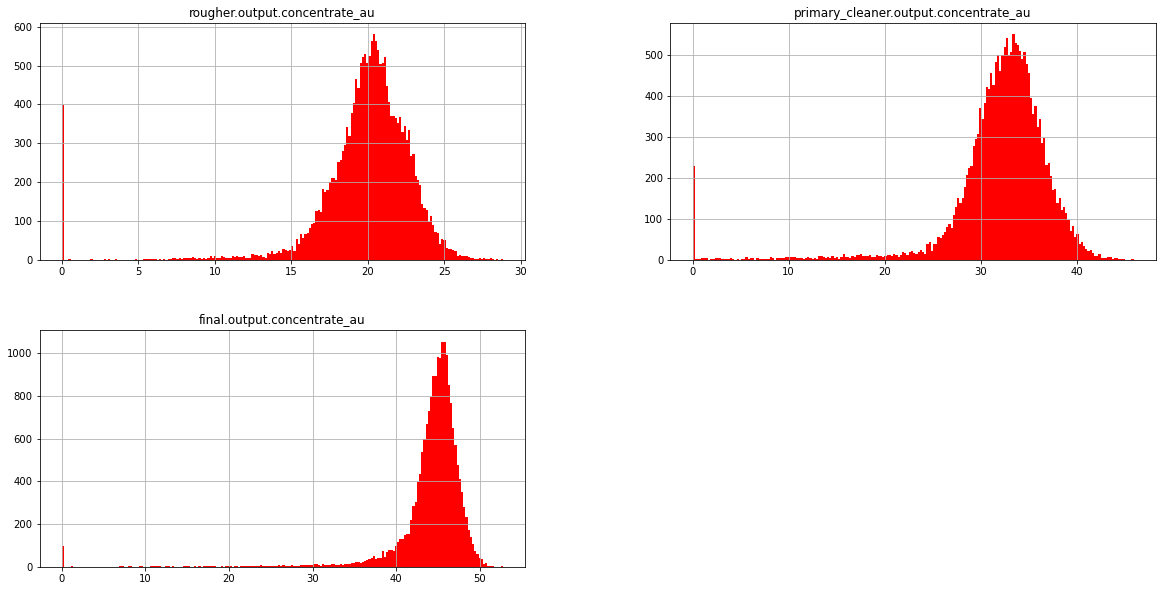

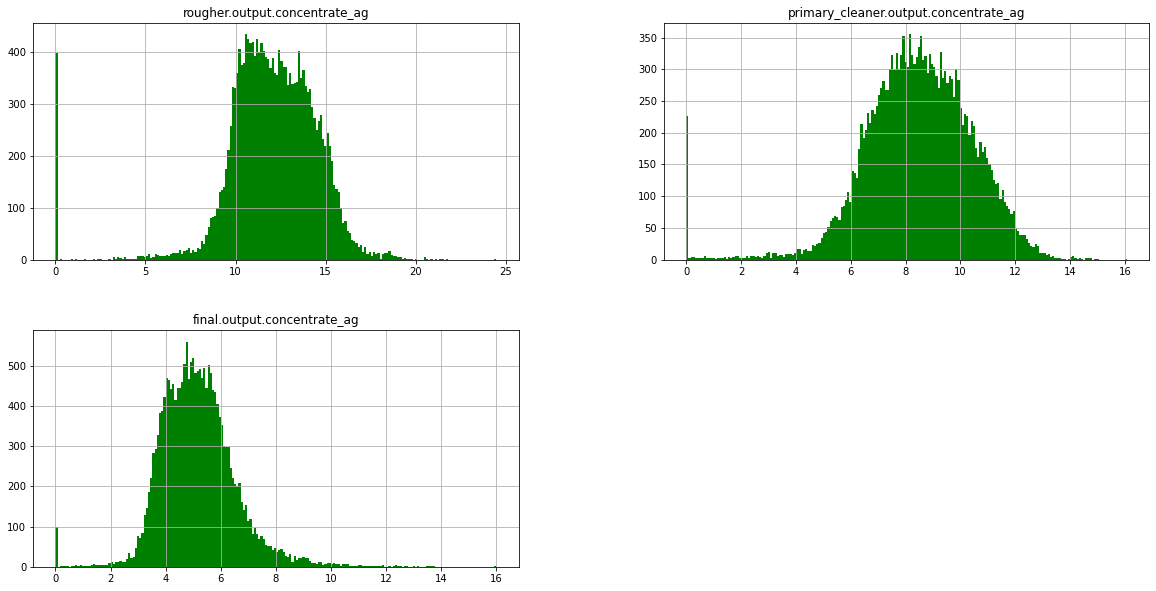

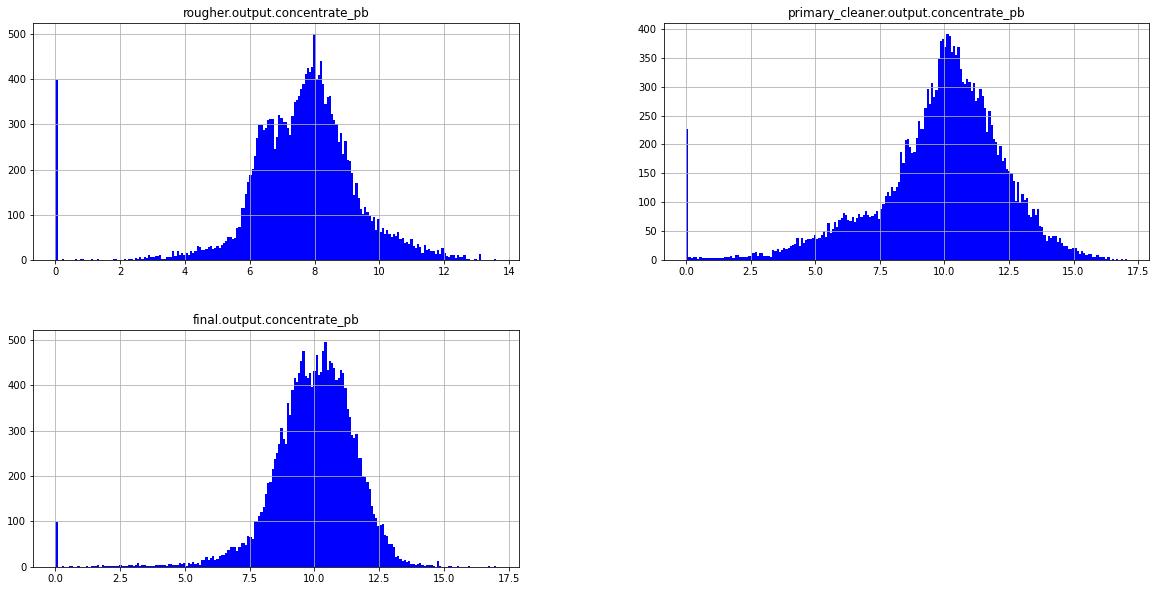

In [19]:
# Визуализируем распределения металлов.

au.hist(figsize=(20, 10), bins=200, color='red')
ag.hist(figsize=(20, 10), bins=200, color='green')
pb.hist(figsize=(20, 10), bins=200, color='blue')

На гистограммах видно, как меняется концентрация металлов при обработке: разброс концентрации золота в исходном сырье становится меньше и сдвигается в большую сторону на каждом этапе очистки (диапазон распределения: 43-46 ед. после очистки, против 18-21 ед. в исходном сырье). Концентрация серебра после очистки, напротив, сдвигается в сторону уменьшения, разброс концентрирации фокусируется в диапазоне 4-6 ед., против изначальных 10-13 ед. Концентрация свинца при очистке увеличивается и сосредотачивается в диапазоне 9-11 ед., против изначальных 7-8 ед.

### 2.2.  Анализ распределения размеров гранул сырья на обучающей и тестовой выборках

Text(0, 0.5, 'Частота')

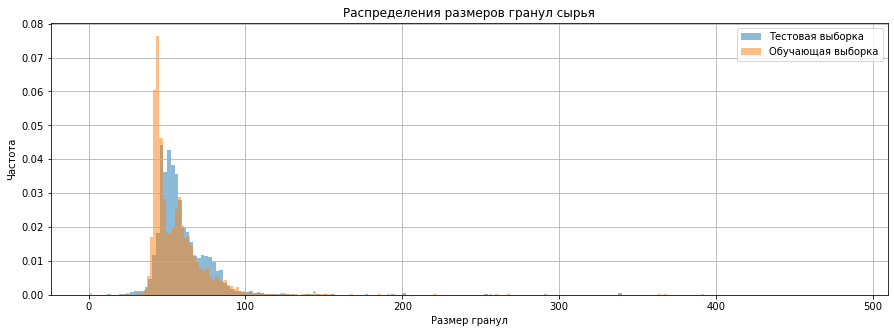

In [20]:
# Построим гистограммы распределения размеров гранул сырья тестовой и обучающей выборки в одной плоскости.

df_train_upd['rougher.input.feed_size'].hist(figsize=(15, 5), bins=200, density=True, alpha=0.5)
df_test_upd['rougher.input.feed_size'].hist(figsize=(15, 5), bins=200, density=True, alpha=0.5)

plt.legend(['Тестовая выборка', 'Обучающая выборка'])
plt.title('Распределения размеров гранул сырья')
plt.xlabel('Размер гранул')
plt.ylabel('Частота')

Существенного разичия между размером гранул сырья в тестовой и обучающей выборках не наблюдается, за исключением выброса в диапазоне 30-40 на тестовой выборке

In [21]:
# Выведем разницу в таблице описательной статистики.

(df_train_upd['rougher.input.feed_size'].describe() -\
 df_test_upd['rougher.input.feed_size'].describe()) / df_train['rougher.input.feed_size'].describe()

count    0.632560
mean     0.069005
std      0.155912
min      0.995200
25%      0.103634
50%      0.080092
75%      0.052612
max      0.190680
Name: rougher.input.feed_size, dtype: float64

Разница незначительнпя: стандартные отклонения в обучающей выборке на 15% выше тестовой, медианные и средние значения выборок различаются менее, чем на 10%.

### 2.3.  Исследование суммарных концентраций веществ

In [22]:
# Сумма концентраций металлов на различных этапах технологического процесса.

feed_concentrate = df_full['rougher.input.feed_au'] + df_full['rougher.input.feed_ag'] + df_full['rougher.input.feed_pb']
rougher_concentrate = df_full['rougher.output.concentrate_au'] + df_full['rougher.output.concentrate_ag'] + df_full['rougher.output.concentrate_pb']
final_concentrate = df_full['final.output.concentrate_au'] + df_full['final.output.concentrate_ag'] + df_full['final.output.concentrate_pb']

Text(0, 0.5, 'Частота')

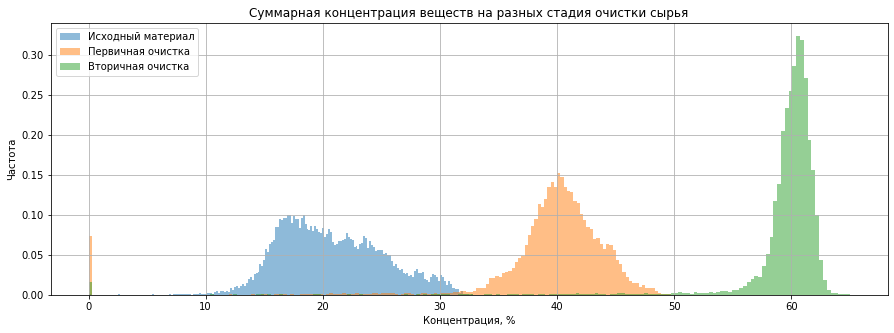

In [23]:
# Гистограмма концентраци металоов.

feed_concentrate.hist(figsize=(15, 5), bins=200, density=True, alpha=0.5)
rougher_concentrate.hist(figsize=(15, 5), bins=200, density=True, alpha=0.5)
final_concentrate.hist(figsize=(15, 5), bins=200, density=True, alpha=0.5)

plt.legend(['Исходный материал', 'Первичная очистка', 'Вторичная очистка'])
plt.title('Суммарная концентрация веществ на разных стадия очистки сырья')
plt.xlabel('Концентрация, %')
plt.ylabel('Частота')

На основании гистограммы, примем решение об отборе данных для модели. Так, для концентрации исходного материала не будем отбрасывать "хвост" от 0 до 10 ед. Для этапа первчной очистки удалим данные концентрации менее 30 ед., а для вторичной очистики = данные менее 50 ед.

In [24]:
df_full_new = df_full.query('@rougher_concentrate > 29 & @final_concentrate > 49')
df_full_new.shape

(18328, 86)

In [25]:
df_train_new = pd.merge(df_train_upd, df_full_new[['rougher.output.recovery', 'final.output.recovery']],
        left_index=True, right_index=True)

# Проверим обучающую выборку.

df_train_new.shape

(13359, 54)

Аналогично, для тестовой выборки.

In [26]:
df_test_new = pd.merge(df_test_upd, df_full_new[['rougher.output.recovery', 'final.output.recovery']],
         left_index=True, right_index=True)

# Проверим тестовую выборку.

df_test_new.shape

(4969, 54)

На данном этапе исследования было осуществлено изучение концентрации Au, Ag, Pb на различных этапах технологического процесса: сырье, первичной и вторичной очитках, а также размера гранул в обучающей и тестовой выборках, существенных раздичий между которыми не выявлено. Исследование суммарных концентраций Au, Ag, Pb на различных этапах, позволило выявить диапазон значений для дальнейшего обучения модели.

## 3. Модель

### 3.1.  Функция для вычисления итогового sMAPE

Создадим функцию для вычисления sMAPE.

In [27]:
def sMAPE(y_target, y_predicted):
    error = np.mean(abs(y_target - y_predicted) / ((abs(y_target) + abs(y_predicted)) / 2)) * 100
    return error

Создадим функцию для вычисления итоговой sMAPE.

In [28]:
def final_sMAPE(sMAPE_rougher, sMAPE_final):
    return (0.25 * sMAPE_rougher + 0.75 * sMAPE_final)

### 3.2. Обучение моделей

Целевым признаком является восстановленная из золотой руды, в результате технологических процессов очистки, доля золота.
Выделим из датасета признаки и целевой признак.

In [29]:
train = df_train_new.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
train_rougher = df_train_new['rougher.output.recovery']
train_final = df_train_new['final.output.recovery']

test = df_test_new.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
test_rougher = df_test_new['rougher.output.recovery']
test_final = df_test_new['final.output.recovery']

In [30]:
# Используем пайплайн для автоматизации обучения моделей.

custom_score = make_scorer(sMAPE, greater_is_better=False)

DTR_model = make_pipeline(StandardScaler(),DecisionTreeRegressor())
RFR_model = make_pipeline(StandardScaler(),RandomForestRegressor())

In [31]:
# Переберем параметры моделей при обучении.

DTR_params= {"decisiontreeregressor__max_depth":[1,10]}

RFR_params = {"randomforestregressor__n_estimators":[5,100],
             "randomforestregressor__max_depth":[1,10]}

Создаем кросс-валидацию для моделей.

In [32]:
# Для регресси дерева решений.

grid_rougher_DTR = RandomizedSearchCV(DTR_model,
                                      cv=5,
                                      param_distributions=DTR_params,
                                      scoring=custom_score)

grid_final_DTR = RandomizedSearchCV(DTR_model,
                                    cv=5,
                                    param_distributions=DTR_params,
                                    scoring=custom_score,
                                    n_jobs=-1)




# Для регресси случайного леса.

grid_rougher_RFR = RandomizedSearchCV(RFR_model,
                                      cv=5,
                                      param_distributions=RFR_params,
                                      scoring=custom_score, n_jobs=-1)

grid_final_RFR = RandomizedSearchCV(RFR_model,
                                      cv=5,
                                      param_distributions=RFR_params,
                                      scoring=custom_score, n_jobs=-1)

Обчуим различные модели и проверим их качество кросс-валидацией.

In [33]:
# Обучение дерева решений.

grid_rougher_DTR.fit(train, train_rougher)
grid_final_DTR.fit(train, train_final)

C:\Users\Roman\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\Roman\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('decisiontreeregressor',
                                              DecisionTreeRegressor())]),
                   n_jobs=-1,
                   param_distributions={'decisiontreeregressor__max_depth': [1,
                                                                             10]},
                   scoring=make_scorer(sMAPE, greater_is_better=False))

In [34]:
# Обучение случайного леса.

grid_rougher_RFR.fit(train, train_rougher)
grid_final_RFR.fit(train, train_final)

C:\Users\Roman\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\Roman\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('randomforestregressor',
                                              RandomForestRegressor())]),
                   n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': [1,
                                                                             10],
                                        'randomforestregressor__n_estimators': [5,
                                                                                100]},
                   scoring=make_scorer(sMAPE, greater_is_better=False))

In [35]:
print('Параметры лучшего дерева решений:', grid_rougher_DTR.best_params_)
print('Лучший результат кросс-валидации дерева решений:', grid_rougher_DTR.best_score_, '\n')
print('Лучший результат кросс-валидации дерева решений:', grid_final_DTR.best_params_)
print('Лучший результат кросс-валидации дерева решений:', grid_final_DTR.best_score_, '\n')

print('Параметры лучшего случайного леса:', grid_rougher_RFR.best_params_)
print('Лучший результат кросс-валидации случайного леса:', grid_rougher_RFR.best_score_,'\n')
print('Параметры лучшего случайного леса:', grid_final_RFR.best_params_)
print('Лучший результат кросс-валидации случайного леса:', grid_final_RFR.best_score_)

Параметры лучшего дерева решений: {'decisiontreeregressor__max_depth': 1}
Лучший результат кросс-валидации дерева решений: -7.211434985490612 

Лучший результат кросс-валидации дерева решений: {'decisiontreeregressor__max_depth': 1}
Лучший результат кросс-валидации дерева решений: -9.488627342734073 

Параметры лучшего случайного леса: {'randomforestregressor__n_estimators': 100, 'randomforestregressor__max_depth': 10}
Лучший результат кросс-валидации случайного леса: -6.566575032748723 

Параметры лучшего случайного леса: {'randomforestregressor__n_estimators': 100, 'randomforestregressor__max_depth': 10}
Лучший результат кросс-валидации случайного леса: -9.113253616595033


Лучшее качество модели получилось у случайного леса.

Рассчитаем симметричное среднее абсолютное процентное отклонение на модели дерева решений.

In [36]:
final_sMAPE(grid_rougher_DTR.best_score_, grid_final_DTR.best_score_)

-8.919329253423207

Рассчитаем симметричное среднее абсолютное процентное отклонение на модели случайного леса.

In [37]:
final_sMAPE(grid_rougher_RFR.best_score_, grid_final_RFR.best_score_)

-8.476583970633456

Лучшие результаты у случайного леса.

### 3.3  Проверка модели

Для сравнения со случайным лесом используем константную с модель дамми-регрессором и расчетом медианных знаечний.

In [38]:
# Инициируем константную модель дамми-регрессором с расчетом медианных знаечний.

constant_rougher = make_pipeline(StandardScaler(), DummyRegressor(strategy='median'))
constant_final = make_pipeline(StandardScaler(), DummyRegressor(strategy='median'))

In [39]:
# Обучим модель.

constant_rougher.fit(train, train_rougher)
constant_final.fit(train, train_final)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('dummyregressor', DummyRegressor(strategy='median'))])

In [40]:
# Спрогнозируем метрики.

constant_rougher_prediction = constant_rougher.predict(test)
constant_final_prediction = constant_final.predict(test)

In [41]:
final_sMAPE(sMAPE(test_rougher,constant_rougher_prediction), sMAPE(test_final, constant_final_prediction))

6.9750072804665715

Симметричное среднее абсолютное процентное отклонение получилась ниже, чем на константной модели,ошибка в тесте на допустимом уровне.

## 4. Итоги исследования

- в процессе исследования были обнаружены пропуски 34 параметров в тестовом датасете, проблема была устранена,
- среди двух рассмотренных моделей регрессии - дерево решений и случайный лес - наилучшим оказалась последняя.